# Incremental Collaborative Filtering

## Setup

In [16]:
import torch
import torch.nn as nn
from torch import tensor
from torch.optim import SGD
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.nn.modules.loss import _Loss

import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from abc import ABCMeta, abstractmethod
from tqdm import tqdm
from typing import List, Callable
from functools import update_wrapper

In [17]:
%matplotlib inline

In [2]:
!pip install -q watermark
%reload_ext watermark
%watermark -m -iv -u -t -d

Last updated: 2021-10-25 10:31:51

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

IPython: 5.5.0
torch  : 1.9.0+cu111



## Losses

### Wrappers

Below we define several wrappers for well known losses that are defined and implemented in the Pytorch library. The main idea is that we need to flatten our prediction before we pass them accordingly to the chosen loss function.

In [2]:
class FlatLoss():
    """Same as whatever `func` is, but with flattened input and target."""
    def __init__(self, func: _Loss, axis: int = -1, to_float: bool = False, 
                 is_2d: bool = False, **kwargs):
        self.func = func(**kwargs)
        self.axis = axis
        self.to_float = to_float
        self.is_2d = is_2d
    
        update_wrapper(self, self.func)

    def __repr__(self): 
        return f'FlatLoss of {self.func}'
    
    @property
    def reduction(self) -> str:
        assert hasattr(self.func, 'reduction'), f'{self.func} does not have "reduction" attribute'
        return self.func.reduction
    
    @reduction.setter
    def reduction(self, reduction: str):
        self.func.reduction = reduction

    @property
    def weight(self) -> torch.tensor:
        assert hasattr(self.func, 'weight'), f'{self.func} does not have "weight" attribute'
        return self.func.weight
    
    @weight.setter
    def weight(self, weight: torch.tensor):
        self.func.weight = weight

    def __call__(self, prediction: torch.tensor, target: torch.tensor, **kwargs) -> torch.tensor:
        prediction = prediction.transpose(self.axis, -1).contiguous()
        target = target.transpose(self.axis, -1).contiguous()
        
        if self.to_float:
            target = target.float()
            
        prediction = prediction.view(-1, prediction.shape[-1]) if self.is_2d else prediction.view(-1)
        return self.func.__call__(prediction, target.view(-1), **kwargs)

The FlatLoss class creates a callable that will do whatever the function that we pass would do, but with flattened input and target before the operation.

### Common losses

In [4]:
def FlatCrossEntropyLoss(axis: int = -1, to_float: bool = True, is_2d: bool = False, **kwargs):
    """Same as `nn.CrossEntropyLoss`, but with flattened input and target."""
    return FlatLoss(nn.CrossEntropyLoss, axis=axis, to_float=to_float, is_2d=is_2d, **kwargs)

In [ ]:
def FlatBCELoss(axis: int = -1, to_float: bool = True, is_2d: bool = False, **kwargs):
    """Same as `nn.BCELoss`, but with flattened input and target."""
    return FlatLoss(nn.BCELoss, axis=axis, to_float=to_float, is_2d=is_2d, **kwargs)

In [ ]:
def FlatMSELoss(axis: int = -1, to_float: bool = True, is_2d: bool = False, **kwargs):
    """Same as `nn.MSELoss`, but with flattened input and target."""
    return FlatLoss(nn.MSELoss, axis=axis, to_float=to_float, is_2d=is_2d, **kwargs)

## Metrics

### Recall

In [3]:
def recall_at_k(predictions: List[int], targets: List[int], k: int = 10) -> float:
    """Computes `Recall@k` from the given predictions and targets sets."""
    predictions_set = set(predictions[:k])
    targets_set = set(targets)
    result = len(targets_set & predictions_set) / float(len(targets_set))
    return result

In [4]:
predictions = (5, 6, 32, 67, 1, 15, 7, 89, 10, 43)
targets = (15, 5, 44, 35, 67, 101, 7, 80, 43, 12)

assert recall_at_k(predictions, targets, 5) == .2, 'Recall@k should be equal to 2/10 = 0.2'

### Precision

In [5]:
def precision_at_k(predictions: List[int], targets: List[int], k: int = 10) -> float:
    """Computes `Precision@k` from the given predictions and targets sets."""
    predictions_set = set(predictions[:k])
    targets_set = set(targets)
    result = len(targets_set & predictions_set) / float(len(predictions_set))
    return result

In [6]:
predictions = (5, 6, 32, 67, 1, 15, 7, 89, 10, 43)
targets = (15, 5, 44, 35, 67, 101, 7, 80, 43, 12)

assert precision_at_k(predictions, targets, 5) == .4, 'Recall@k should be equal to 2/5 = 0.4'

## Models

Common neural network architectures for Collaborative Filtering.

This architecture is the simplest one to implement Collaborative Filtering. It only defines the embedding matrices for users and items and the final rating is computed by the dot product of the corresponding rows.

In [9]:
class SimpleCF(nn.Module):
    """
    n_users (int): The number of unique users
    n_items (int): The number of unique items
    factors (int): The dimension of the embedding space
    user_embeddings (torch.tensor): Pre-trained weights for the user embedding matrix
    freeze_users (bool): True if we want to keep the user weights as is (i.e. non-trainable)
    item_embeddings (torch.tensor): Pre-trained weights for the item embedding matrix
    freeze_item (bool): True if we want to keep the item weights as is (i.e. non-trainable)
    init (torch.nn.init): The initialization method of the embedding matrices - default: torch.nn.init.normal_
    """
    def __init__(self, n_users: int, n_items: int, factors: int = 16, 
                 user_embeddings: torch.tensor = None, freeze_users: bool = False,
                 item_embeddings: torch.tensor = None, freeze_items: bool = False,
                 init: torch.nn.init = torch.nn.init.normal_, binary: bool =False, **kwargs):
        super().__init__()
        self.binary = binary
        
        self.user_embeddings = self._create_embedding(n_users, factors, 
                                                      user_embeddings, freeze_users, 
                                                      init, **kwargs)
        self.item_embeddings = self._create_embedding(n_items, factors, 
                                                      item_embeddings, freeze_items,
                                                      init, **kwargs)
        self.sigmoid = nn.Sigmoid()

    def forward(self, u: torch.tensor, i: torch.tensor) -> torch.tensor:
        user_embedding = self.user_embeddings(u)
        user_embedding = user_embedding[:, None, :]
        item_embedding = self.item_embeddings(i)
        item_embedding = item_embedding[:, None, :]
        rating = torch.matmul(user_embedding, item_embedding.transpose(1, 2))
        if self.binary:
            return self.sigmoid(rating)
        return rating
    
    def _create_embedding(self, n_items, factors, weights, freeze, init, **kwargs):
        embedding = nn.Embedding(n_items, factors)
        init(embedding.weight.data, **kwargs)
        
        if weights is not None:
            embedding.load_state_dict({'weight': weights})
        if freeze:
            embedding.weight.requires_grad = False
        
        return embedding

In [10]:
# initialize the model with 100 users, 50 items and a 16-dimensional embedding space
model = SimpleCF(100, 50, 16, mean=0., std=.1, binary=True)

# predict the rating that user 3 would give to item 33
model(torch.tensor([2]), torch.tensor([32]))

tensor([[[0.4973]]], grad_fn=<SigmoidBackward>)

## Step

Incremental Collaborative Filtering algorithms.

In [12]:
class StepBase:
    """
    Defines the interface that all step models here expose.
    This class defines the interface that every Step module should implement.
    Namely, each class should implement five methods:

        batch_fit: To support batch training
        step: To support incremental learning
        predict: To offer recommendations
        save: To save the model parameters
        load: To load the model parameters
    """
    __metaclass__ = ABCMeta
    
    @abstractmethod
    def batch_fit(self, data_loader: torch.utils.data.DataLoader, epochs: int):
        """Trains the model on a batch of user-item interactions."""
        pass
    
    @abstractmethod
    def step(self, user: torch.tensor, item: torch.tensor, 
             rating: torch.tensor, preference: torch.tensor):
        """Trains the model incrementally."""
        pass
    
    @abstractmethod
    def predict(self, user: torch.tensor, k: int):
        """Recommends the top-k items to a specific user."""
        pass
    
    @abstractmethod
    def save(self, path: str):
        """Saves the model parameters to the given path."""
        pass
    
    @abstractmethod
    def load(self, path: str):
        """Loads the model parameters from a given path."""
        pass

In [13]:
class Step(StepBase):
    """Incremental and batch training of recommender systems.
    The step class implements the basic Incremental Collaborative Filtering recommender system.
    Arguments:
        model (torch.nn.Module): The neural network architecture
        objective (Callable): The objective function
        optimizer (Callable): The method used to optimize the objective function. Usually a torch.optim loss function
        conf_func (Callable): A method that converts implicit ratings to confidence scores
        device (str): Either cpu or gpu
    """
    def __init__(self, model: torch.nn.Module, objective: Callable,
                 optimizer: Callable, conf_func: Callable = lambda x: torch.tensor(1),
                 device: str = 'cpu'):
        self.model = model.to(device)
        self.objective = objective
        self.optimizer = optimizer
        self.conf_func = conf_func
        self.device = device

        # check if the user has provided user and item embeddings
        assert self.model.user_embeddings, 'User embedding matrix could not be found.'
        assert self.model.item_embeddings, 'Item embedding matrix could not be found.'

    @property
    def user_embeddings(self):
        return self.model.user_embeddings

    @property
    def item_embeddings(self):
        return self.model.item_embeddings

    def batch_fit(self, data_loader: torch.utils.data.DataLoader, epochs: int = 1):
        """Trains the model on a batch of user-item interactions."""
        self.model.train()
        for epoch in range(epochs):
            with tqdm(total=len(data_loader)) as pbar:
                for _, (features, preferences) in enumerate(data_loader):
                    users = features[:, 0].to(self.device)
                    items = features[:, 1].to(self.device)
                    rtngs = features[:, 2].to(self.device)
                    prefs = preferences.to(self.device)
                    
                    preds = self.model(users, items)
                    confs = self.conf_func(rtngs)
                    
                    if hasattr(self.objective, 'weight'):
                        self.objective.weight = confs
                    
                    loss = self.objective(preds, prefs).mean()
                    loss.backward()
                    
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                    
                    pbar.update(1)

    def step(self, user: torch.tensor, item: torch.tensor, 
             rating: torch.tensor = None, preference: torch.tensor = None):
        """Trains the model incrementally."""
        self.model.train()
        
        user = user.to(self.device)
        item = item.to(self.device)
        rtng = rating.to(self.device)
        pref = preference.to(self.device)
        
        pred = self.model(user, item)
        conf = self.conf_func(rtng)
        
        if hasattr(self.objective, 'weight'):
            self.objective.weight = conf
        
        loss = self.objective(pred, pref)
        loss.backward()
        
        self.optimizer.step()
        self.optimizer.zero_grad()

    def predict(self, user: torch.tensor, k:int = 10) -> torch.tensor:
        """Recommends the top-k items to a specific user."""
        self.model.eval()
        user = user.to(self.device)
        user_embedding = self.user_embeddings(user)
        item_embeddings = self.item_embeddings.weight
        score = item_embeddings @ user_embedding.transpose(0, 1)
        predictions = score.squeeze().argsort()[-k:]
        return predictions.cpu()

    def save(self, path: str):
        """Saves the model parameters to the given path."""
        torch.save(self.model.state_dict(), path)

    def load(self, path: str):
        """Loads the model parameters from a given path."""
        self.model.load_state_dict(torch.load(path))

## Utils

In [14]:
# export
def moving_avg(inputs: list, w: int = 10) -> List[float]:
    """Computes the moving average of a list over a sliding window.
    
    Arguments:
        inputs (list): A list of integers or floats
        w (int): The sliding window that will be used to compute moving averages
    """
    cumsum, moving_avgs = [0], []
    for i, x in enumerate(inputs, 1):
        cumsum.append(cumsum[i-1] + x)
        if i >= w:
            moving_avg = (cumsum[i] - cumsum[i-w]) / w
            moving_avgs.append(moving_avg)
    return moving_avgs

In [15]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

moving_avg(a, 2)

[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]

## Dataset

We will use the popular movielens dataset. First we will download the data and load it into a pandas DataFrame. 

To avoid creating a user and movie vocabularies we turn each user and movie to a categorical feature and use the pandas convenient cat attribute to get the codes.

In [18]:
!wget -q --show-progress http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

ml-1m.zip           100%[===================>]   5.64M  13.5MB/s    in 0.4s    
Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [19]:
# load the data
col_names = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings_df = pd.read_csv('ml-1m/ratings.dat', delimiter='::', names=col_names, engine='python')

# transform users and movies to categorical features
ratings_df['user_id'] = ratings_df['user_id'].astype('category')
ratings_df['movie_id'] = ratings_df['movie_id'].astype('category')

# use the codes to avoid creating separate vocabularies
ratings_df['user_code'] = ratings_df['user_id'].cat.codes.astype(int)
ratings_df['movie_code'] = ratings_df['movie_id'].cat.codes.astype(int)

ratings_df.head()

,user_id,movie_id,rating,timestamp,user_code,movie_code
0,1,1193,5,978300760,0,1104
1,1,661,3,978302109,0,639
2,1,914,3,978301968,0,853
3,1,3408,4,978300275,0,3177
4,1,2355,5,978824291,0,2162


Using the codes we can see how many users and movies are in the dataset.

In [20]:
n_users = ratings_df['user_code'].max() + 1
n_movies = ratings_df['movie_code'].max() + 1

print(f'There are {n_users} unique users and {n_movies} unique movies in the movielens dataset.')

There are 6040 unique users and 3706 unique movies in the movielens dataset.


In [21]:
data_df = ratings_df.sort_values(by='timestamp')

The Step model supports only positive feedback. Thus, we will consider a rating of 5 as positive feedback and discard any other. We want to identify likes with 1 and dislikes with 0.

In [22]:
# more than 4 -> 1, less than 5 -> 0
data_df['preference'] = np.where(data_df['rating'] > 4, 1, 0)
# keep only ones and discard the others
data_df_cleaned = data_df.loc[data_df['preference'] == 1]

data_df_cleaned.head()

,user_id,movie_id,rating,timestamp,user_code,movie_code,preference
999873,6040,593,5,956703954,6039,579,1
1000192,6040,2019,5,956703977,6039,1839,1
999920,6040,213,5,956704056,6039,207,1
999967,6040,3111,5,956704056,6039,2895,1
999971,6040,2503,5,956704191,6039,2309,1


## Training

Following, let us initialize our model.

In [23]:
net = SimpleCF(n_users, n_movies, factors=128, mean=0., std=.1)
objective = lambda pred, targ: targ - pred
optimizer = SGD(net.parameters(), lr=0.06)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Step(net, objective, optimizer, device=device)

Finally, let us get 20% of the data to fit the model for bootstrapping and create the Pytorch Dataset that we will use.

In [24]:
pct = int(data_df_cleaned.shape[0] * .2)
bootstrapping_data = data_df_cleaned[:pct]

We will create a dataset from our Dataframe. We extract four elements: The user code, The movie code, The rating, and The preference.

In [25]:
features = ['user_code', 'movie_code', 'rating']
target = ['preference']

data_set = TensorDataset(torch.tensor(bootstrapping_data[features].values), 
                         torch.tensor(bootstrapping_data[target].values))

Create the Pytorch DataLoader that we will use. Batch size should always be 1 for online training.

In [26]:
data_loader = DataLoader(data_set, batch_size=512, shuffle=False)

Let us now use the batch_fit() method of the Step trainer to bootstrap our model.

In [27]:
model.batch_fit(data_loader)

100%|██████████| 89/89 [00:01<00:00, 73.83it/s]


Then, to simulate streaming we get the remaining data and create a different data set.

In [28]:
data_df_step = data_df_cleaned.drop(bootstrapping_data.index)
data_df_step = data_df_step.reset_index(drop=True)
data_df_step.head()

,user_id,movie_id,rating,timestamp,user_code,movie_code,preference
0,4708,3019,5,963519342,4707,2806,1
1,4708,2918,5,963519342,4707,2710,1
2,4708,1240,5,963519448,4707,1148,1
3,4708,1285,5,963519448,4707,1193,1
4,4717,1262,5,963519507,4716,1170,1


In [ ]:
# create the DataLoader
stream_data_set = TensorDataset(torch.tensor(data_df_step[features].values), 
                                torch.tensor(data_df_step[target].values))
stream_data_loader = DataLoader(stream_data_set, batch_size=1, shuffle=False)

k = 10 # we keep only the top 10 recommendations
recalls = []
known_users = []

## Evaluation

In [29]:
with tqdm(total=len(stream_data_loader)) as pbar:
    for idx, (features, preferences) in enumerate(stream_data_loader):
        itr = idx + 1
        
        user = features[:, 0]
        item = features[:, 1]
        rtng = features[:, 2]
        pref = preferences
        
        if user.item() in known_users:
            predictions = model.predict(user, k)
            recall = recall_at_k(predictions.tolist(), item.tolist(), k)
            recalls.append(recall)
            model.step(user, item, rtng, pref)
        else:
            model.step(user, item, rtng, pref)
            
        known_users.append(user.item())
        pbar.update(1)

100%|██████████| 181048/181048 [23:05<00:00, 130.70it/s]


Last but not least, we visualize the results of the recall@10 metric, using a moving average window of 5k elements.

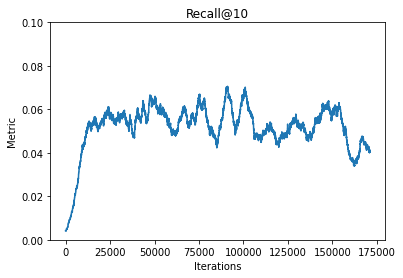

In [30]:
avgs = moving_avg(recalls, 5000)

plt.title('Recall@10')
plt.xlabel('Iterations')
plt.ylabel('Metric')
plt.ylim(0., .1)
plt.plot(avgs)
plt.show()

Finally, save the model's weights.

In [32]:
model.save('positive_step.pt')